### Trabalho Prático

##### Alunos

- Arnaldo Antônio Inácio Silva
- Eduardo Henrique Pessoa Alves
- Gabriel Mendes Oliveira Pedrosa da Costa 
- Lucas Freitas de Barros

##### Disciplina

Processamento Digital de Imagem

### Objetivo

Criar um sistema para abrir, manipular e salvar imagens RGB com 24 bits/pixel (8 bits/componente/pixel).

O sistema deve:

1. Correlacionar uma máscara m x n com __offset__, sobre R, G e B. O offset e o filtro (dimensões e valores da máscara) são definidos em um arquivo (.txt) a parte com a estrutura descrita abaixo.

<span style="letter-spacing: 3px;">m, n, offset</span>  
<span style="letter-spacing: 3px;">X<sub>0,0</sub> X<sub>0,1</sub> X<sub>0,2</sub> ... X<sub>0,n-1</sub></span>  
<span style="letter-spacing: 3px;">X<sub>1,0</sub> X<sub>1,1</sub> X<sub>1,2</sub> ... X<sub>1,n-1</sub></span>  
<span style="letter-spacing: 3px;">X<sub>2,0</sub> X<sub>2,1</sub> X<sub>2,2</sub> ... X<sub>2,n-1</sub></span>  
...  
<span style="letter-spacing: 3px;">X<sub>m-1,0</sub> X<sub>m-1,1</sub> X<sub>m-1,2</sub> ... X<sub>m-1,n</sub></span>

Além disso, os filtros:

- Gaussiano 5x5
- Sobel horizontal
- Sobel vertical

Devem ser utilizados com extensão por zeros. 

O valor absoluto deve ser aplicado na visualização do sobel, juntamente com a expansão de histograma para [0, 255].

2. O filtro pontual abaixo, (a) aplicado em RGB, (b) aplicado à banda Y do YIQ, com conversão posterior para RGB.

![Filtro Pontual](filtropontual.png)

## Código

##### Importando bibliotecas

As bibliotecas necessárias são importadas e baixadas caso não estejam presentes.

In [61]:
import importlib
import subprocess
import sys
import os

def install_and_import(package, alias=None, install_name=None):
    try:
        if alias:
            globals()[alias] = importlib.import_module(package)
        else:
            globals()[package] = importlib.import_module(package)
        print(f'O pacote "{package}" já está instalado.')
    except ImportError:
        install_name = install_name or package
        print(f'O pacote "{package}" não está instalado. Instalando "{install_name}" agora...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', install_name])
        if alias:
            globals()[alias] = importlib.import_module(package)
        else:
            globals()[package] = importlib.import_module(package)

# Pacotes a serem verificados/instalados
packages = [
    ('numpy', 'np'),
    ('matplotlib.pyplot', 'plt', 'matplotlib'),
    ('PIL.Image', 'Image', 'Pillow')
]

for package_info in packages:
    install_and_import(*package_info)

O pacote "numpy" já está instalado.
O pacote "matplotlib.pyplot" já está instalado.
O pacote "PIL.Image" já está instalado.


##### Abrindo, mostrando e salvando imagens

Aqui, apenas operações de abrir, salvar e mostrar imagens são aplicadas, sem utilizar qualquer processamento.

In [62]:
# Função para carregar a imagem e obter as dimensões
def load_image(path):
    img = Image.open(path)
    img = np.array(img)
    return img

# Função para exibir a imagem
def display_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Função para salvar a imagem
def save_image(img, path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    img = Image.fromarray(img)
    img.save(path)

##### Constantes

Para posterior utilização, RGB é uma constante com valor 3, indicando a quantidade de bandas (partindo do R e indo ao G) onde será aplicado o filtro pontual no RGB.

Da mesma forma, a constante YIQ indica a quantidade de bandas (neste caso, apenas a banda Y) onde será aplicado o filtro pontual.

In [63]:
RGB = 3
YIQ = 1

##### Conversão RGB → YIQ

A conversão RGB → YIQ pode ser representada de forma matricial:

$$yiq = T_{RGB→YIQ} \cdot rgb$$

Onde:

- $rgb = \begin{bmatrix}R\\G\\B\end{bmatrix}$
- $T_{RGB→YIQ} = \begin{bmatrix}0.299 & 0.587 & 0.114 \\0.596 & -0.275 & 0.321 \\0.211 & -0.523 & 0.312\end{bmatrix}$

Portanto, a operação no método `rgb_to_yiq` pode ser representada como:

$$yiq = \begin{bmatrix}Y\\I\\Q\end{bmatrix} = \begin{bmatrix}0.299 & 0.587 & 0.114 \\0.596 & -0.275 & 0.321 \\0.211 & -0.523 & 0.312\end{bmatrix} \cdot \begin{bmatrix}R\\G\\B\end{bmatrix}$$

##### Conversão YIQ → RGB

A conversão YIQ → RGB pode ser representada de forma matricial:

$$rgb = T_{YIQ → RGB} \cdot yiq$$

Onde:

- $yiq = \begin{bmatrix}Y\\I\\Q\end{bmatrix}$
- $T_{YIQ→RGB} = \begin{bmatrix}1.0 & 0.956 & 0.621 \\1.0 & -0.272 & -0.647 \\1.0 & -1.106 & 1.703\end{bmatrix}$

Portanto, a operação no método `yoq_to_rgb` pode ser representada como:

$$rgb = \begin{bmatrix}R\\G\\B\end{bmatrix} = \begin{bmatrix}1.0 & 0.956 & 0.621 \\1.0 & -0.272 & -0.647 \\1.0 & -1.106 & 1.703\end{bmatrix} \cdot \begin{bmatrix}Y\\I\\Q\end{bmatrix}$$

Além disso, ao final, os valores são truncados entre 0 e 255 como inteiros, para garantir que nada fuja do range.

In [64]:
# Funções de conversão RGB para YIQ e vice-versa
def rgb_to_yiq(rgb):
    transformation_matrix = np.array([[0.299, 0.587, 0.114],
                                      [0.596, -0.275, -0.321],
                                      [0.211, -0.523, 0.312]])
    yiq = np.dot(rgb, transformation_matrix.T)
    return yiq

def yiq_to_rgb(yiq):
    transformation_matrix = np.array([[1.0, 0.956, 0.621],
                                      [1.0, -0.272, -0.647],
                                      [1.0, -1.106, 1.703]])
    rgb = np.dot(yiq, transformation_matrix.T)
    return np.clip(rgb, 0, 255).astype(np.uint8)

##### Aplicando Filtro Pontual

O filtro abaixo deve ser aplicado:

![Filtro Pontual](filtropontual.png)

Para tal, considerando uma banda qualquer, dois são os casos possíveis:

1. O caso em que o valor do componente é menor ou igual a 128.
2. O caso em que o valor do componente é maior que 128.

Portanto, temos:

$$
y = 
\begin{cases} 
\frac{255}{128} \cdot x, & \text{se } x \leq 128 \\[10pt]
\frac{255 \cdot (255 - x)}{128}, & \text{se } x > 128
\end{cases}
$$


In [65]:
def point_filter(img, n):
    # i = 0 para R/Y, 1 para G/I, 2 para B/Q
    for i in range(n):    
        # Banda específica
        channel = img[:, :, i]

        # Condição 1: x <= 128
        mask1 = channel <= 128
        img[:, :, i][mask1] = (255 / 128 * channel[mask1]).astype(np.uint8)
        
        # Condição 2: x > 128
        mask2 = channel > 128
        img[:, :, i][mask2] = (255 * (255 - channel[mask2]) / 128).astype(np.uint8)
    return img

##### Abrindo Máscara

A máscara é aberta, retornando os valores de linha (m), coluna (n), offset e a matriz presentes no arquivo .txt correspondente.

In [66]:
def load_mask(file_name):
    with open(file_name, 'r') as file:
        # Lê a primeira linha para obter m, n e offset
        first_line = file.readline().strip()
        m, n, offset = map(int, first_line.split(','))

        # Inicializa uma lista para armazenar a matriz
        matrix = []

        # Lê as linhas seguintes e preenche a matriz
        for _ in range(m):
            line = file.readline().strip()
            values = list(map(float, line.split()))
            matrix.append(values)
    
    return m, n, offset, matrix

##### Aplicando Extensão por Zeros

O primeiro passo para aplicar o filtro local é aplicar a extensão por zeros correspondente ao ponto em questão.

Desta forma, para aplicar o filtro pontual, é necessario primeiramente definir o pivô da máscara, uma vez que, no nosso caso, o pivô sempre tenderá ao centro do filtro.

$$p = \left(\frac{m}{2}, \frac{n}{2}\right) \quad \text{onde } \frac{m}{2} \text{ e } \frac{n}{2} \in \mathbb{Z}$$

Com isso, é definido a quantidade de colunas à esquerda e à direita da imagem serão adicionadas, bem como a quantidade de linhas abaixo e acima da imagem serão adicionadas:

- Quantidade de colunas adicionadas à esquerda = $p_Y - 0$
- Quantidade de colunas adicionadas à direita = $n - (p_Y+1)$
- Quantidade de linhas adicionadas acima = $p_X - 0$
- Quantidade de linhas adicionadas abaixo = $m - (p_X + 1)$

Onde:

- $p_X$: Índice da linha ocupada pelo pivô
- $p_Y$: Índice da coluna ocupada pelo pivô

A partir disso, uma quantidade de linhas e colunas nas posições adequadas são adicionadas, conforme as máscaras presentes, lembrando que cada posição adicionada deve conter três canais em nível 0, onde cada canal representa R, G e B.

In [67]:
def applying_zero_extension(img, m, n):
    newImg = img.copy()

    indexPivot = {"row_pivt": m//2, "column_pivt": n//2}
    amount_columns_on_left = indexPivot["column_pivt"] - 0
    amount_columns_on_right = n - (indexPivot["column_pivt"]+1)
    amount_rows_on_top = indexPivot["row_pivt"] - 0
    amount_rows_on_bottom = m - (indexPivot["row_pivt"]+1)

    
    # Criando as extensões de zeros diretamente
    newImg = np.pad(
        newImg,
        pad_width=(
            (amount_rows_on_top, amount_rows_on_bottom),
            (amount_columns_on_left, amount_columns_on_right),
            (0, 0)
        ),
        mode='constant',
        constant_values=0
    )

    
    return newImg, indexPivot


#### Aplicando Filtro Local

Agora o método de aplicação de filtro local. A partir dele, qualquer filtro presente no arquivo .txt poderá ser aplicado.

Para tal, o filtro recebe a máscara (`mask`), a quantidade de linhas da máscara (`m`), a quantidade de colunas da máscara (`n`) e o `offset` que será aplicado ao resultado final. Todos esses valores são provenientes do arquivo `.txt` presente no diretório `filters` do presente trabalho.

O primeiro passo é criar uma imagem do tamanho da imagem original, afinal, uma vez que a extensão por zeros está sendo aplicada, a imagem final terá as mesmas dimensões que a original. 

Feito isso, é extraída a imagem com extensão por zeros, jutno aos índices do pivô da máscara.

Por fim, a imagem é percorrida para preencher a imagem final. A cada ponto da imagem percorrida, é feita uma submatriz da vizinhança com as mesmas dimensões da máscara. Essa submatriz é multiplicada pela matriz da máscara, o valor é somado e acrescido de um offset.

Como a máscara é bidimensional e a imagem tem três dimensões a nível de matrizes (linha, coluna e cada célula contém os canais RGB), então a máscara é expandida para uma terceira dimensão, contendo os valores agora distribuídos na terceira dimensão para que possa ser multiplicado pela submatriz da imagem.

Ao final, para garantir que o valor de nenhuma das bandas exceda 255 ou fique abaixo de 0, é feito um truncamento, garantindo também que os valores permaneçam inteiros.

In [68]:
def applying_local_filter(mask, m, n, offset, img):
    new_img = np.zeros(img.shape)

    new_img_with_zeros, pivot = applying_zero_extension(img, m, n)
    mask = np.array(mask)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            sub_matrix = new_img_with_zeros[
                i:i + m,
                j:j + n
            ]

            filtered_value = np.sum(mask[:, :, np.newaxis] * sub_matrix, axis=(0, 1))
            filtered_value += offset

            new_img[i, j] = np.clip(filtered_value, 0, 255).astype(np.uint8)

    return new_img.astype(np.uint8)


#### Expansão de Histograma

Aqui há a aplicação de expansão de histograma. Nesse caso primeiro o histograma é calculado, é aplicada a função de distribuição acumulada e então há a normalização do histograma.

In [69]:
def expand_histogram(img):
    # Calcula o histograma da imagem
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0,256])
    
    # Calcula a função de distribuição acumulada (CDF)
    cdf = hist.cumsum()
    
    # Normaliza a CDF para o intervalo [0, 255]
    cdf_normalized = cdf * 255 / cdf[-1]
    
    # Aplica a CDF normalizada para expandir o histograma
    img_expanded = cdf_normalized[img.astype(np.uint8)]
    
    return img_expanded.astype(np.uint8)

In [70]:
def plot_histogram(img, title):
    # Calcula o histograma da imagem
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0,256])
    
    # Plota o histograma
    plt.figure()
    plt.plot(hist, color='black')
    plt.title(title)
    plt.xlabel('Intensidade de pixel')
    plt.ylabel('Número de pixels')
    plt.show()

##### Mostrando imagens

As imagens são carregadas nas suas respectivas variáveis.  
A imagem `testpat.1k.color2.tif` é atribuída à variável `imgTif` e em seguida mostrada.  
O mesmo é feito em relação à imagem `Shapes.png`, que é atribuída à variável `imgPng`.

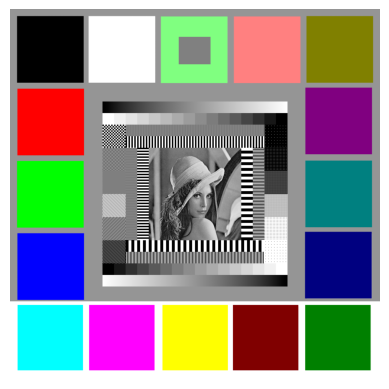

In [71]:
# carregar e processar imagem
imgTif = load_image('testpat.1k.color2.tif')
display_image(imgTif)

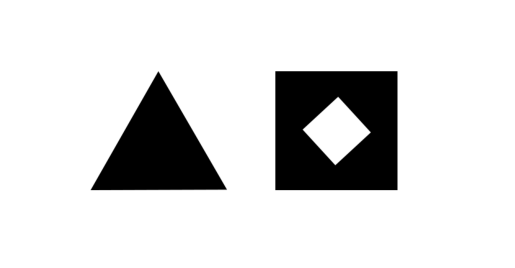

In [72]:
imgPng = load_image('Shapes.png')
display_image(imgPng)

### Questão 1

Aplicando Filtro na imagem `.png`.

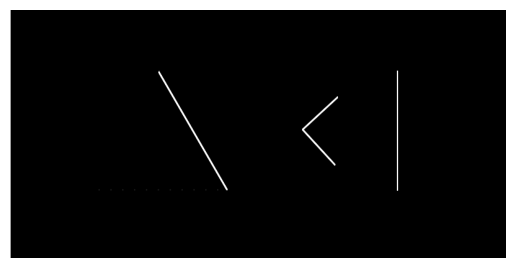

In [73]:
m, n, offset, mask = load_mask("filters/filtroSobelHorizontal1.txt")

img = applying_local_filter(mask, m, n, offset, imgPng.copy())
display_image(img)
save_image(img, "results\qt1\imgpng.png")

Aplicando Filtro na imagem `.tif`.

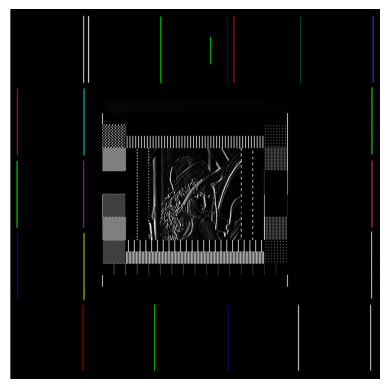

In [74]:
img = applying_local_filter(mask, m, n, offset, imgTif.copy())
display_image(img)
save_image(img, "results\qt1\imgtif.tif")

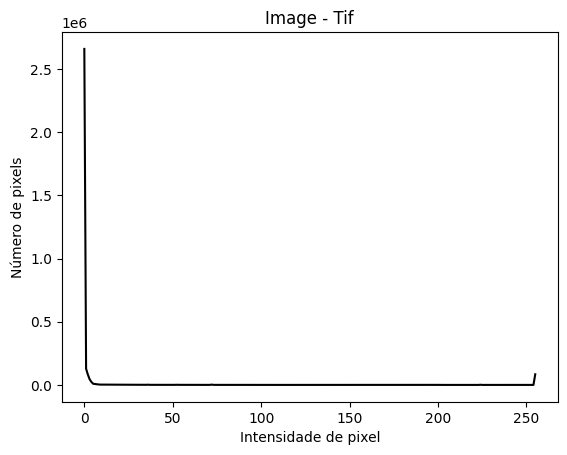

In [77]:
plot_histogram(img, "Image - Tif")

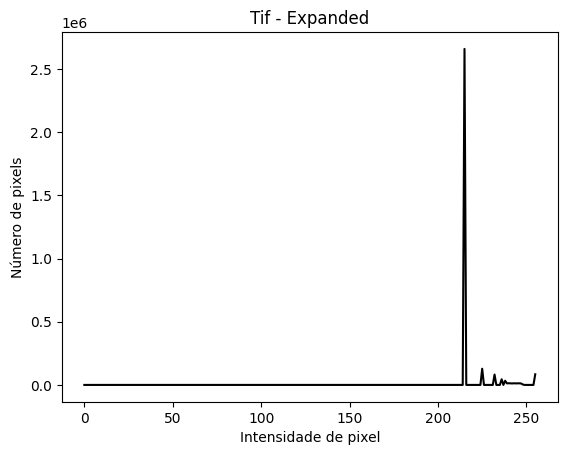

In [78]:
img = expand_histogram(img)
plot_histogram(img, "Tif - Expanded")

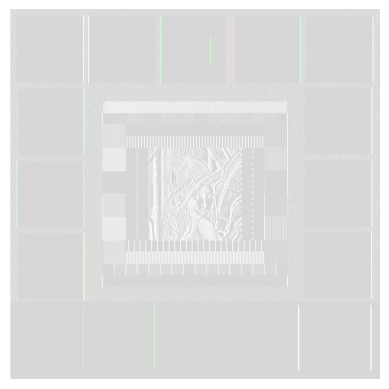

In [80]:
display_image(img)

### Questão 2

##### Letra A

Aqui a operação de filtro pontual é aplicada com as duas imagens. Vale ressaltar que são criadas cópias das imagens antes das operações para garantir que a imagem original não seja alterada por conta do gerenciamento de memória do Numpy (reutilização do objeto original, fazendo alterações por referência).

Neste caso, o filtro é aplicado nas três bandas RGB.

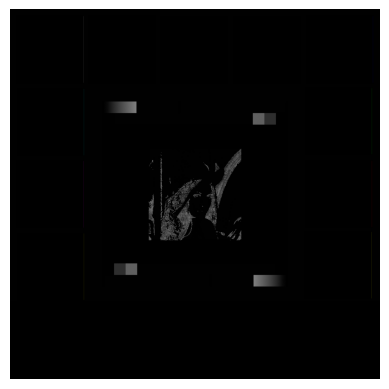

In [ ]:
display_image(point_filter(imgTif.copy(), RGB))
save_image(point_filter(imgTif.copy(), RGB), "results\qt2\qt2_A_imgTif.tif")

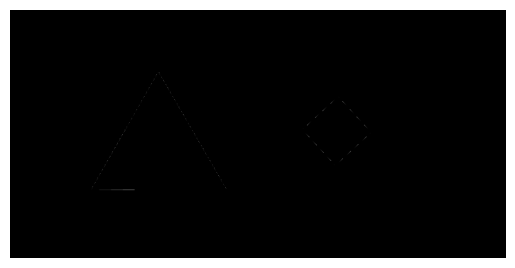

In [ ]:
display_image(point_filter(imgPng.copy(), RGB))
save_image(point_filter(imgPng.copy(), RGB), "results\qt2\qt2_A_imgPng.png")

##### Letra B

Aqui a operação de filtro pontual é aplicada com as duas imagens. Vale ressaltar que são criadas cópias das imagens antes das operações para garantir que a imagem original não seja alterada por conta do gerenciamento de memória do Numpy (reutilização do objeto original, fazendo alterações por referência).

Neste caso, a imagem é convertida para YIQ e só então o filtro é aplicado na banda Y apenas. Após a aplicação do filtro, a imagem volta para RGB e é salva.

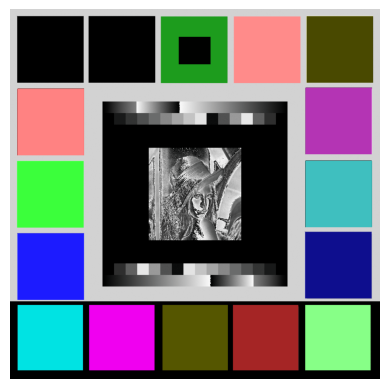

In [ ]:
display_image(yiq_to_rgb(point_filter(rgb_to_yiq(imgTif.copy()), YIQ)))
save_image(yiq_to_rgb(point_filter(rgb_to_yiq(imgTif.copy()), YIQ)), "results\qt2\qt2_B_imgTif.tif")

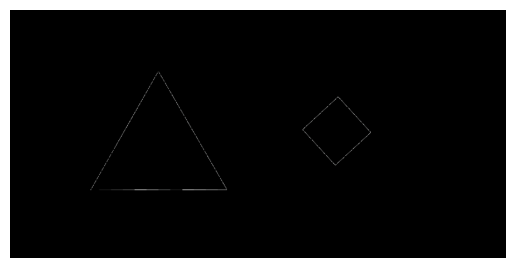

In [ ]:
display_image(yiq_to_rgb(point_filter(rgb_to_yiq(imgPng.copy()), YIQ)))
save_image(yiq_to_rgb(point_filter(rgb_to_yiq(imgPng.copy()), YIQ)), "results\qt2\qt2_B_imgPng.png")